Title: Sentiment Analysis on a Custom Text Dataset    
Author: Raikibul Hasan

**Table of contents**<a id='toc0_'></a>    
- [Preparation](#toc1_)    
    - [Install libraries](#toc1_1_1_)    
    - [Import libraries](#toc1_1_2_)    
- [Data Expolaration](#toc2_)  
    - [Load the dataset & overview of the data](#_)     
    - [Identify and handling missing data](#_)      
    - [Visualize the distribution](#_)   
- [Sentiment Analysis](#toc3_)
    <!-- - [Overview of the data](#)   
    - [Extract keyword using PKE](#toc2_1_1_)    
    - [Split the article into an array/list of individual sentences](#toc2_1_2_)    
    - [Map the sentences which contain the keywords](#toc2_1_3_)    
    - [Get the sense of the word](#toc2_1_4_)    
    - [first distractor generate from WordNet](#toc2_1_5_)    
    - [Second distractor generator](#toc2_1_6_)    
    - [Find and map the distractors to the keywords](#toc2_1_7_)     -->
    <!--/- [Show generates MCQ](#toc2_1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Preparation](#toc0_)
In this section, we will import the necessary libraries and dataset.

### <a id='toc1_1_1_'></a>[Install libraries](#toc0_)
***If you have installed  library once skip it otherwise make installed varibale false and run***

In [1]:
installed = True

In [2]:
def install_library():
    !pip install pandas
    !pip install numpy
    !pip install worldcloud
    !pip install nltk
    !pip install seaborn
    !pip install tensorflow
    !pip install matplotlib
    !pip install scikit-learn
    !pip install xgboost


if not installed:
    install_library()


In [3]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Flatten
import xgboost as xgb
import warnings
import shap

c:\ProgramData\Anaconda3\envs\sentLens-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
warnings.filterwarnings("ignore")
np.random.seed(42)

In [5]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# 0. Data Exploration

In [6]:
#
data.head(10)

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0
5,2023-03-29 22:57:20+00:00,1641212975012016128,@nytimes No! Chat Gpt has been putting togethe...,cordydbarb,0.0,0.0
6,2023-03-29 22:57:06+00:00,1641212917868646400,@ylzkrtt Yes also by chat gpt you can make gen...,gomezfidelphani,1.0,0.0
7,2023-03-29 22:57:02+00:00,1641212902375063552,@robinhanson @razibkhan Most people haven't he...,nikocosmonaut,0.0,0.0
8,2023-03-29 22:56:52+00:00,1641212856984109072,Yours Robotically - by Shaun Usher - Letters o...,lawyermarketer,0.0,0.0
9,2023-03-29 22:56:49+00:00,1641212845441585152,This is a metaphor for the limited perception ...,ashleighgrente2,2.0,0.0


In [7]:
# Basic statistics for each column
statistics_table = data.describe(include='all').transpose()
print("Statistics:")
statistics_table.head()

Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,500036,475394,2023-03-08 14:41:33+00:00,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,500030,500007,billnco,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content,500030,493744,Chat GPT,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
username,500002,250006,Ben_Ccarter,1776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
like_count,499974.0,NaN,NaN,NaN,7.123208,216.366469,0.0,0.0,1.0,2.0,64094.0


In [8]:
data.isnull().sum()

date              0
id                6
content           6
username         34
like_count       62
retweet_count    62
dtype: int64

In [9]:
# Calculate the percentage of missing values for each column
missing_values = data.isnull().sum() / len(data) * 100
missing_values_table = pd.DataFrame({'Column': data.columns, 'Percentage Missing': missing_values})
missing_values_table.head()

,Column,Percentage Missing
date,date,0.000000
id,id,0.001200
content,content,0.001200
username,username,0.006800
like_count,like_count,0.012399


In [10]:
#Drop missing values
data=data.dropna()
data.isnull().sum()

date             0
id               0
content          0
username         0
like_count       0
retweet_count    0
dtype: int64

In [11]:
data['sentiment']=data['like_count'].apply(lambda x:'positive' if x>0 else 'negative')

In [12]:
data=data.drop(columns=['date', 'id', 'username', 'like_count', 'retweet_count'])

In [13]:
# Splitting data into training and testing
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)


In [14]:
data.columns

Index(['content', 'sentiment'], dtype='object')

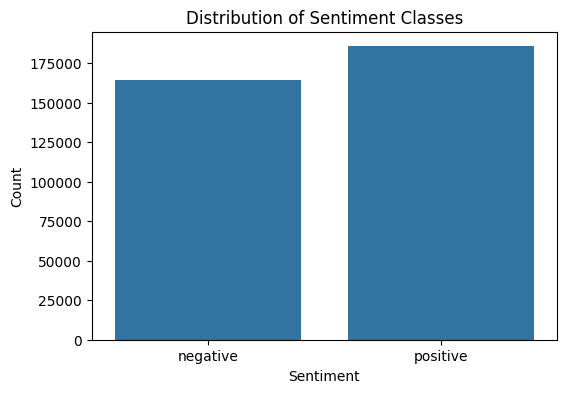

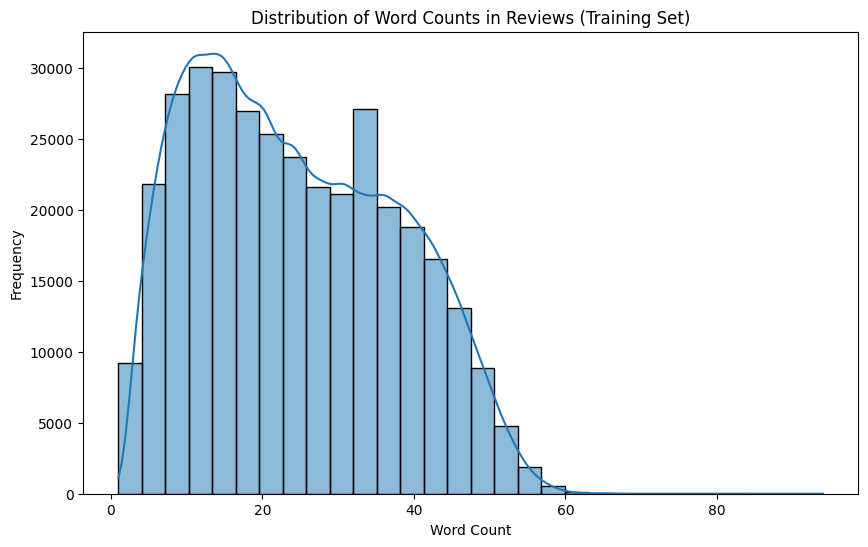

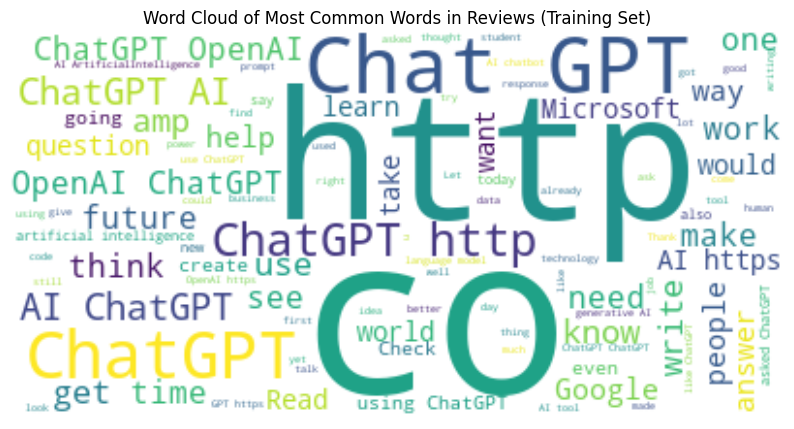

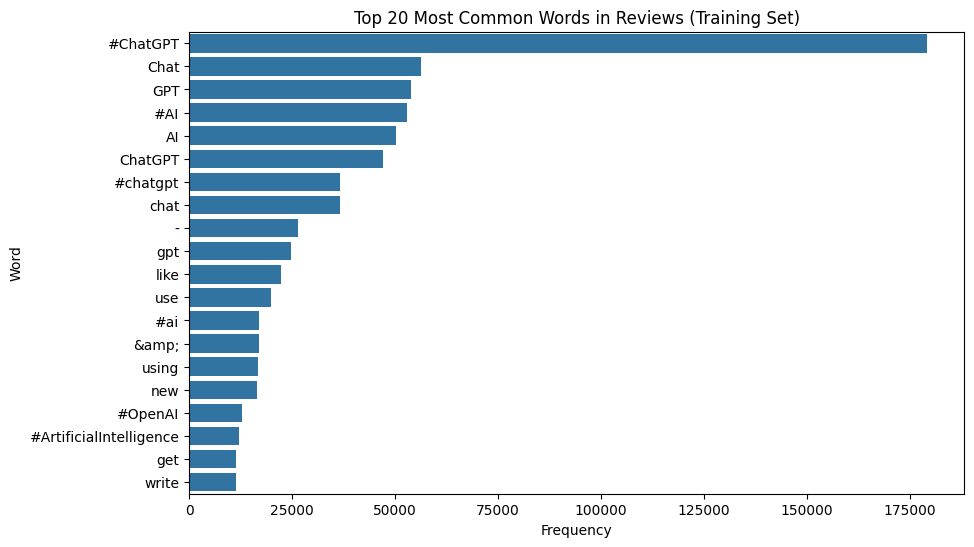

In [15]:
# Graphival representation of the train data
# Plot distribution of like count classes
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train_data)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Add a column for word count in the training data
train_data['word_count'] = train_data['content'].apply(lambda x: len(x.split()))

# Plot distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Counts in Reviews (Training Set)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Generate word cloud for the most common words in the training data
stop_words = set(stopwords.words('english'))
text = ' '.join(train_data['content'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Reviews (Training Set)')
plt.show()

# Frequency of most common words
words = text.split()
words_filtered = [word for word in words if word.lower() not in stop_words]
word_freq = Counter(words_filtered)

# Display top 20 most common words
most_common_words = word_freq.most_common(20)
most_common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=most_common_words_df)
plt.title('Top 20 Most Common Words in Reviews (Training Set)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

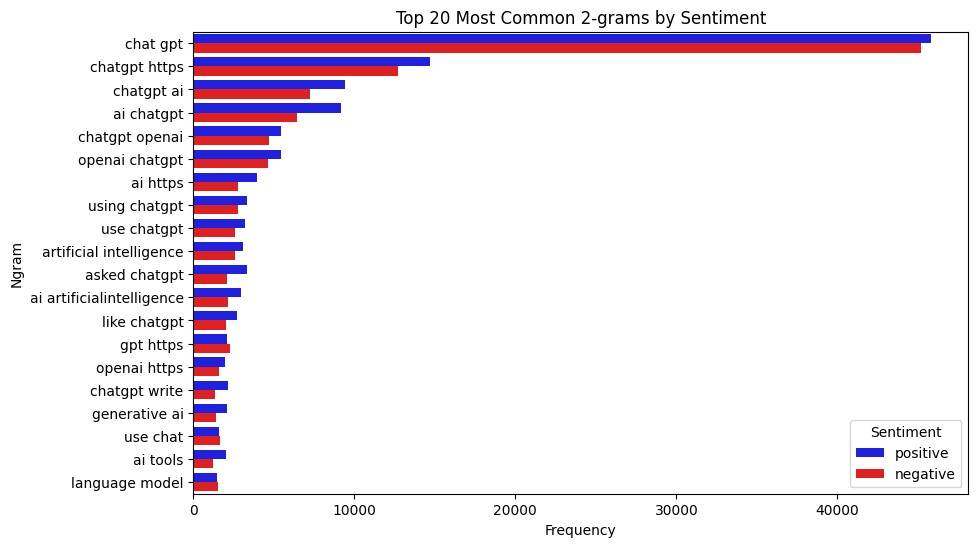

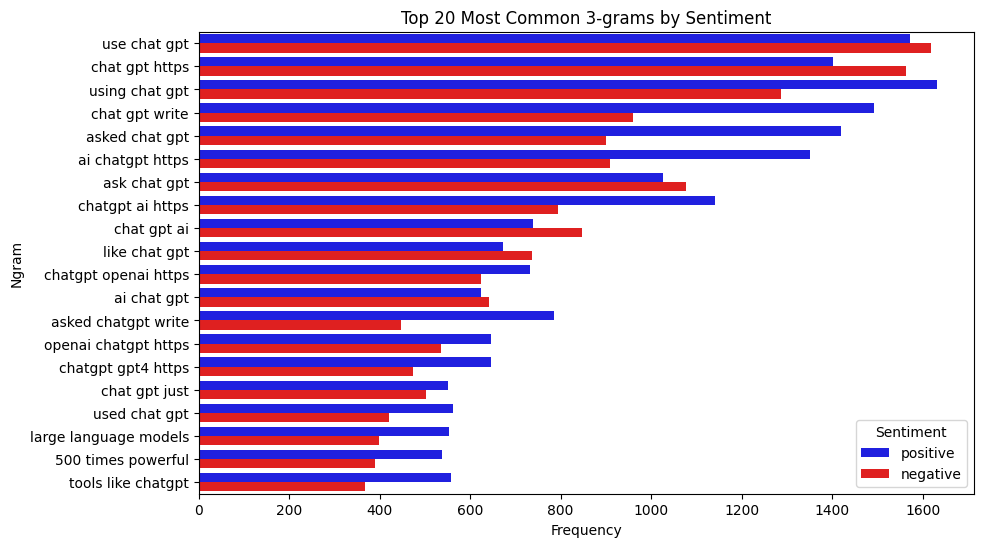

In [16]:
# Function to plot the most common n-grams (bigrams or trigrams)

def plot_ngrams_by_sentiment(data, sentiment_col='sentiment', text_col='content', ngram_range=(2, 2), top_n=20):
    """
    Plots the top n n-grams by sentiment from a text dataset.

    Parameters:
    -----------
    data : pandas.DataFrame
        A DataFrame containing the text data and sentiment labels.
    sentiment_col : str, optional, default='sentiment'
        The name of the column in the DataFrame that contains sentiment labels (e.g., 'positive', 'negative').
    text_col : str, optional, default='text'
        The name of the column in the DataFrame that contains the text data.
    ngram_range : tuple, optional, default=(2, 2)
        The range of n-grams to be extracted. (2, 2) extracts bigrams.
    top_n : int, optional, default=20
        The number of top n-grams to display in the plot.

    Returns:
    --------
    None
        This function displays a plot
    """
    
    # Initialize CountVectorizer to extract n-grams from the text data, ignoring English stop words.
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    # Fit the vectorizer on the text data and transform the text into a sparse matrix of n-gram counts.
    X = vectorizer.fit_transform(data[text_col])
    
    # Get the list of n-grams (features) from the vectorizer.
    ngrams = vectorizer.get_feature_names_out()
    
    # Sum the counts of each n-gram across all documents to get total frequencies.
    ngram_counts = np.array(X.sum(axis=0)).flatten()
    
    # Create a DataFrame containing n-grams and their total frequencies.
    ngram_freq_df = pd.DataFrame({'Ngram': ngrams, 'Total_Frequency': ngram_counts})
    
    # Calculate the frequency of each n-gram in positive sentiment texts.
    ngram_freq_df['Positive_Freq'] = X[data[sentiment_col] == 'positive'].sum(axis=0).A1
    
    # Calculate the frequency of each n-gram in negative sentiment texts.
    ngram_freq_df['Negative_Freq'] = X[data[sentiment_col] == 'negative'].sum(axis=0).A1
    
    # Sort the DataFrame by total frequency and keep only the top n n-grams.
    ngram_freq_df = ngram_freq_df.sort_values(by='Total_Frequency', ascending=False).head(top_n)
    
    # Reshape the DataFrame for plotting: one row per n-gram per sentiment.
    ngram_freq_melted = ngram_freq_df.melt(id_vars='Ngram', value_vars=['Positive_Freq', 'Negative_Freq'], 
                                           var_name='Sentiment', value_name='Sentiment_Frequency')
    
    # Convert the sentiment column to display 'positive' or 'negative' for easier interpretation.
    ngram_freq_melted['Sentiment'] = ngram_freq_melted['Sentiment'].apply(lambda x: 'positive' if 'Positive' in x else 'negative')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Sentiment_Frequency', y='Ngram', hue='Sentiment', data=ngram_freq_melted, palette={'positive': 'blue', 'negative': 'red'})
    
    plt.title(f'Top {top_n} Most Common {ngram_range[0]}-grams by Sentiment')
    plt.xlabel('Frequency')
    plt.ylabel('Ngram')
    
    plt.legend(title='Sentiment')
    
    plt.show()


plot_ngrams_by_sentiment(train_data, ngram_range=(2, 2), top_n=20)
plot_ngrams_by_sentiment(train_data, ngram_range=(3, 3), top_n=20)


In [17]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocesses the input text by converting it to lowercase, removing special characters, 
    tokenizing, removing stopwords, and applying lemmatization.

    Parameters:
    -----------
    text : str
        The input string containing the text to be processed.

    Returns:
    --------
    str
        The processed text after applying all preprocessing steps.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text into individual tokens
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Apply lemmatization to each token
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string to form the processed text
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the training data
train_data['processed_text'] = train_data['content'].apply(preprocess_text)

In [18]:
train_data_processed = train_data[['sentiment', 'processed_text']]

In [21]:
train_data

,content,sentiment,word_count,processed_text
160131,Soon you guys wont even be arguing amongst you...,negative,16,soon guy wont even arguing amongst anymore cha...
176417,I noticed something odd with #ChatGPT yesterda...,negative,40,noticed something odd chatgpt yesterday asked ...
225350,@um_fess chat gpt,negative,3,umfess chat gpt
105709,Attention specialty coffee connoisseurs! Embra...,positive,29,attention specialty coffee connoisseur embrace...
306637,#ChatGPT on Broadsens's #wireless #vibration #...,negative,40,chatgpt broadsenss wireless vibration sensor i...
...,...,...,...,...
259202,@business Employees are at the mercy of organi...,positive,17,business employee mercy organization welcome w...
365887,"@jabunna It can do it, but chat gpt has been n...",negative,16,jabunna chat gpt neutered politically correct
131940,CHATGPT IS NOW FINDING BUGS IN DATABASES\n#Cha...,negative,10,chatgpt finding bug database chatgpt database ...
146875,The latest The Whyte-Hall Journal! https://t.c...,positive,12,latest whytehall journal httpstcodsxupkm thank...


In [20]:
# Load pre-trained GloVe embeddings
glove_embeddings = {}
with open("glove.6B.50d.txt", "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_embeddings[word] = vector

# Function to get the average GloVe embedding for a sentence
def get_avg_glove(sentence):
    """
    Computes the average GloVe embedding for a given sentence.

    Parameters:
    -----------
    sentence : str
        The input sentence for which the average GloVe embedding is to be calculated.

    Returns:
    --------
    numpy.ndarray
        The average GloVe embedding vector for the sentence.
    """
    tokens = word_tokenize(sentence)
    embedding = np.mean([glove_embeddings[word] for word in tokens if word in glove_embeddings], axis=0)
    return embedding

# Apply GloVe embeddings to the processed text in the training data
train_data_processed['glove_embeddings'] = train_data_processed['processed_text'].apply(get_avg_glove)

# Handling any NaN values that might result from missing words
train_data_processed['glove_embeddings'] = train_data_processed['glove_embeddings'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(50))

# Convert the list of embeddings into a NumPy array for further processing
glove_embeddings_array = np.stack(train_data_processed['glove_embeddings'].values)


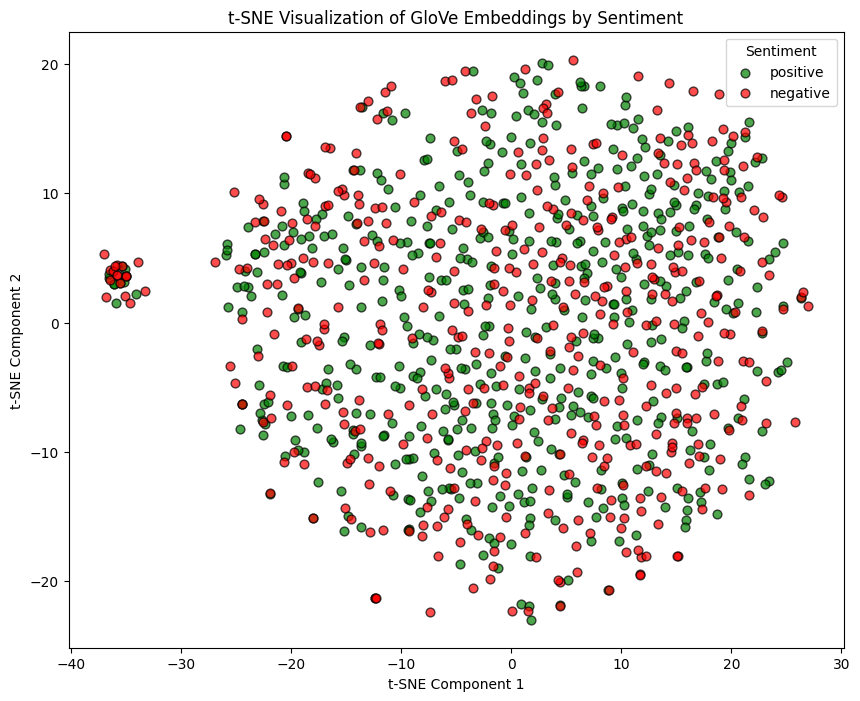

In [21]:
# GloVe Embeddings Plot

# Sample a subset of embeddings for visualization
sample_size = min(1000, len(glove_embeddings_array))
sample_indices = np.random.choice(len(glove_embeddings_array), sample_size, replace=False)
sample_embeddings = glove_embeddings_array[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Map sentiments to colors
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

# Applying t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of GloVe Embeddings by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


In [23]:
sample_sentiments

27116     positive
18245     positive
469066    positive
305375    negative
229331    positive
            ...   
498476    positive
190387    positive
110637    positive
460907    positive
165936    negative
Name: sentiment, Length: 1000, dtype: object

In [22]:
# GloVe Embeddings Plot

# Sample a subset of embeddings for visualization
sample_size = min(1000, len(glove_embeddings_array))
sample_indices = np.random.choice(len(glove_embeddings_array), sample_size, replace=False)
sample_embeddings = glove_embeddings_array[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Map sentiments to colors
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

# Applying t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of GloVe Embeddings by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


KeyboardInterrupt: 

In [24]:
# Combined GloVe, 1-gram TF-IDF, and 2-gram/3-gram TF-IDF Features

# Compute 1-gram (unigram) TF-IDF features
tfidf_vectorizer_unigram = TfidfVectorizer(max_features=1000)
tfidf_features_unigram = tfidf_vectorizer_unigram.fit_transform(train_data_processed['processed_text']).toarray()

# Compute 2-gram or 3-gram TF-IDF features
tfidf_vectorizer_ngram = TfidfVectorizer(max_features=1000, ngram_range=(2, 3))
tfidf_features_ngram = tfidf_vectorizer_ngram.fit_transform(train_data_processed['processed_text']).toarray()

# Combine GloVe embeddings with 1-gram and n-gram (2-gram or 3-gram) TF-IDF features
glove_embeddings_array = np.stack(train_data_processed['glove_embeddings'].values)
combined_features = np.hstack([glove_embeddings_array, tfidf_features_unigram, tfidf_features_ngram])

# Sample a subset of combined features for visualization
sample_size = min(1000, len(combined_features))
sample_indices = np.random.choice(len(combined_features), sample_size, replace=False)
sample_features = combined_features[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Apply t-SNE to reduce combined features to 2D space
tsne = TSNE(n_components=2, random_state=42)
combined_embeddings_2d = tsne.fit_transform(sample_features)

# Visualize the combined embeddings with a legend
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(combined_embeddings_2d[idx, 0], combined_embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of Combined GloVe, 1-gram TF-IDF, and 2-gram/3-gram TF-IDF Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


MemoryError: Unable to allocate 2.61 GiB for an array with shape (349981, 1000) and data type float64